### Inputs

(**Please modify it accordingly**)

In [ ]:
python train_caption_en.py exp.name=caption_4ds_en_batch8 model.detector.checkpoint=/home/naver1/Documents/sjjung/grit/checkpoints/detector_checkpoint_4ds.pth optimizer.freezing_xe_epochs=10 optimizer.freezing_sc_epochs=10 optimizer.finetune_xe_epochs=0 optimizer.finetune_sc_epochs=0
    
    
    
    

In [21]:
vocab_path = '/home/naver1/Documents/sjjung/grit/data/coco/coco-cn-version1805v1.1/vocab.json'
checkpoint = "/home/naver1/Documents/sjjung/grit/outputs/caption_4ds_cn/checkpoint_best_test.pth"



### Intialize a Hydra Config

In [22]:
import sys
sys.path.append("..")

import os
from omegaconf import OmegaConf
from hydra.core.global_hydra import GlobalHydra
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

# initialize hydra config
GlobalHydra.instance().clear()
initialize(config_path="./configs/caption")
config = compose(config_name='coco_cn_config.yaml', overrides=[f"exp.checkpoint={checkpoint}"])

In [23]:
import torch

# model
from models.common.attention import MemoryAttention
from models.caption.detector import build_detector
from models.caption import Transformer, GridFeatureNetwork, CaptionGenerator

In [24]:
# dataset
from PIL import Image
from datasets.caption.field import TextField
from datasets.caption.transforms import get_transform
from engine.utils import nested_tensor_from_tensor_list

device = torch.device(f"cuda:0")

### Build a model

In [25]:
detector = build_detector(config).to(device)

grit_net = GridFeatureNetwork(
    pad_idx=config.model.pad_idx,
    d_in=config.model.grid_feat_dim,
    dropout=config.model.dropout,
    attn_dropout=config.model.attn_dropout,
    attention_module=MemoryAttention,
    **config.model.grit_net,
)
cap_generator = CaptionGenerator(
    vocab_size=config.model.vocab_size,
    max_len=config.model.max_len,
    pad_idx=config.model.pad_idx,
    cfg=config.model.cap_generator,
    dropout=config.model.dropout,
    attn_dropout=config.model.attn_dropout,
    **config.model.cap_generator,
)

model = Transformer(
    grit_net,
    cap_generator,
    detector=detector,
    use_gri_feat=config.model.use_gri_feat,
    use_reg_feat=config.model.use_reg_feat,
    config=config,
)
model = model.to(device)

# load checkpoint
if os.path.exists(config.exp.checkpoint):
    checkpoint = torch.load(config.exp.checkpoint, map_location='cpu')
    missing, unexpected = model.load_state_dict(checkpoint['state_dict'], strict=False)
    print("model missing:", len(missing))
    print("model unexpected:", len(unexpected))
    
model.cached_features = False

# prepare utils
transform = get_transform(config.dataset.transform_cfg)['valid']
text_field = TextField(vocab_path=vocab_path)

model missing: 0
model unexpected: 0


In [26]:
text_field = TextField(vocab_path='/home/naver1/Documents/sjjung/grit/data/coco/coco-cn-version1805v1.1/vocab.json')

In [27]:
torch.tensor([text_field.vocab.stoi['zho_Hans']])[None,:]

tensor([[203]])

In [39]:
text_field.vocab.stoi

defaultdict(<function datasets.caption.vocab._default_unk_index()>,
            {'<unk>': 0,
             '<pad>': 1,
             '<bos>': 2,
             '<eos>': 3,
             'ace_Arab': 4,
             'ace_Latn': 5,
             'acm_Arab': 6,
             'acq_Arab': 7,
             'aeb_Arab': 8,
             'afr_Latn': 9,
             'ajp_Arab': 10,
             'aka_Latn': 11,
             'amh_Ethi': 12,
             'apc_Arab': 13,
             'arb_Arab': 14,
             'ars_Arab': 15,
             'ary_Arab': 16,
             'arz_Arab': 17,
             'asm_Beng': 18,
             'ast_Latn': 19,
             'awa_Deva': 20,
             'ayr_Latn': 21,
             'azb_Arab': 22,
             'azj_Latn': 23,
             'bak_Cyrl': 24,
             'bam_Latn': 25,
             'ban_Latn': 26,
             'bel_Cyrl': 27,
             'bem_Latn': 28,
             'ben_Beng': 29,
             'bho_Deva': 30,
             'bjn_Arab': 31,
             'bjn_Latn': 3

In [28]:
text_field.vocab.stoi['zho_Hans']

203

In [29]:
text_field.vocab.stoi

defaultdict(<function datasets.caption.vocab._default_unk_index()>,
            {'<unk>': 0,
             '<pad>': 1,
             '<bos>': 2,
             '<eos>': 3,
             'ace_Arab': 4,
             'ace_Latn': 5,
             'acm_Arab': 6,
             'acq_Arab': 7,
             'aeb_Arab': 8,
             'afr_Latn': 9,
             'ajp_Arab': 10,
             'aka_Latn': 11,
             'amh_Ethi': 12,
             'apc_Arab': 13,
             'arb_Arab': 14,
             'ars_Arab': 15,
             'ary_Arab': 16,
             'arz_Arab': 17,
             'asm_Beng': 18,
             'ast_Latn': 19,
             'awa_Deva': 20,
             'ayr_Latn': 21,
             'azb_Arab': 22,
             'azj_Latn': 23,
             'bak_Cyrl': 24,
             'bam_Latn': 25,
             'ban_Latn': 26,
             'bel_Cyrl': 27,
             'bem_Latn': 28,
             'ben_Beng': 29,
             'bho_Deva': 30,
             'bjn_Arab': 31,
             'bjn_Latn': 3

### Load and Transform An Image

In [30]:
img_path = '/home/naver1/Documents/sjjung/grit/data/coco/coco-en/test2014/COCO_test2014_000000000016.jpg'


In [31]:
rgb_image = Image.open(img_path).convert('RGB')
image = transform(rgb_image)
images = nested_tensor_from_tensor_list([image]).to(device)
# rgb_image

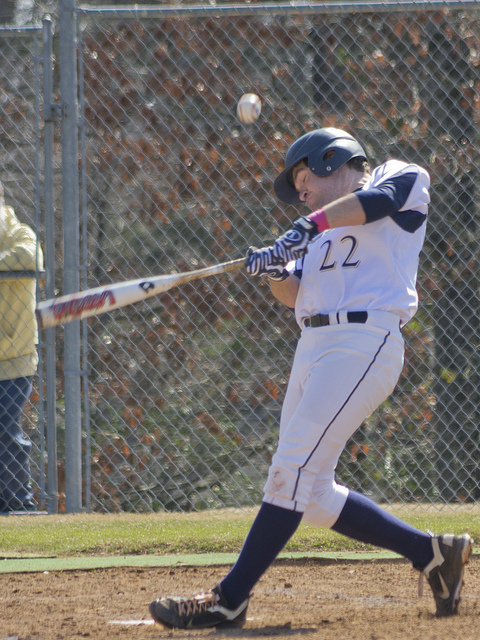

In [32]:
rgb_image

### Inference and Decode

In [33]:
text_field.vocab.stoi['zho_Hans']

203

In [34]:
text_field.vocab.itos[207]

'▁一'

In [35]:
seq=torch.tensor([text_field.vocab.stoi['ary_Arab']])[None,:]

In [36]:
seq[0][0]

tensor(16)

In [38]:
with torch.no_grad():
    
    out, _ = model(images,                   
                   seq=None,
                   bos_idxs = [text_field.vocab.stoi['ary_Arab']],
                   use_beam_search=True,
                   max_len=config.model.beam_len,
                   eos_idx=config.model.eos_idx,
                   beam_size=config.model.beam_size,
                   out_size=1,
                   return_probs=False,
                  )
    caption = text_field.decode(out, join_words=True)[0]                                                
    print(caption)

tensor([[16]], device='cuda:0')
名棒球击球球运动棒球棒球比赛


In [ ]:
caption

In [ ]:
torch.__version__